In [1]:
import math
from collections import OrderedDict
from pathlib import Path
from random import randint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import textstat
from pymer4.models import Lmer

sns.set_theme(style="darkgrid")

## Data Collection

For this part you need the following files: scores and summaries from the SummaReranker and the baseline, the original texts and the gold standard labels. Those files can be found in the data folder of this project. <br>
Here it is important to get them in the right order so the predictions for both systems match the original text

In [2]:
#add your path to the data folder
DATA_FOLDER = Path.home() / "Documents" / "Projects" / "lmem_test" / "data"

summaReranker_summary = DATA_FOLDER / "summareranker"/ "scores_r1.pkl"
summaReranker_summary = pd.read_pickle(summaReranker_summary)

pegasus_finetuned_summary = DATA_FOLDER / "pegasus_finetuned"/ "scored_summaries_finetuned.pkl"
pegasus_finetuned_summary = pd.read_pickle(pegasus_finetuned_summary)

pegasus_notfinetuned_summary = DATA_FOLDER / "pegasus_large"/ "scored_summaries.pkl"
pegasus_notfinetuned_summary = pd.read_pickle(pegasus_notfinetuned_summary)

original_text = DATA_FOLDER / "original_text"/ "test_text.pkl"
original_text = pd.read_pickle(original_text)

labels = DATA_FOLDER / "gold_standard"/ "test_label.pkl"
labels = pd.read_pickle(labels)

In [3]:
#create a dictionary with original_text index, reranker summary and a corresponding Rouge 1 score
summaReranker = {}
for element in summaReranker_summary:
    for ind, summary in enumerate(labels):
        if element[1] == summary:
            summaReranker[ind] = [element[0], element[2]]
            
#sort the dictionary based on the original text order            
summaReranker = OrderedDict(sorted(summaReranker.items())) 

ranker_total_scores = [v[1] for x,v in summaReranker.items()]

In [4]:
basemodel_unfinetuned = {}
for ind, x in enumerate(pegasus_notfinetuned_summary):
    index_val = randint(0,len(x))
    value = x[1][index_val]
    summary = x[0][index_val]
    basemodel_unfinetuned[ind] = [summary, value]
    
pegasus_unfinetuned_scores = [v[1]/100 for k,v in basemodel_unfinetuned.items()]  

In [5]:
basemodel_finetuned = {}
for ind, x in enumerate(pegasus_finetuned_summary):
    index_val = randint(0,len(x))
    value = x[1][index_val]
    summary = x[0][index_val]
    basemodel_finetuned[ind] = [summary, value]
    
pegasus_reddit_scores = [v[1]/100 for k,v in basemodel_finetuned.items()]  

Now that we have everything in the structure that we want, we can calculate the scores for readability, the amount of difficult words, sentence count and the amount of words present in the original texts in order to see the relationshipo between those charecterstics and the Rouge 1 score. 

In [6]:
number_of_words = [len(nltk.word_tokenize(text)) for text in original_text]

difficult_words = [textstat.difficult_words(text) for text in original_text]

sentence_count = [textstat.sentence_count(text) for text in original_text]

flesch_reading_ease = [textstat.flesch_reading_ease(text) for text in original_text]

In [7]:
f"Mean Rouge 1 score Summareranker: {np.mean(ranker_total_scores)} for finetuned pegasus model: {np.mean(pegasus_reddit_scores)}"

'Mean Rouge 1 score Summareranker: 0.2805817708415109 for finetuned pegasus model: 0.24608570727737403'

## Data Visualization

In the following section some visualization will be created. The data has been sorted in an accending order for the text characteristics. The plots can be seen below. 

In [8]:
def get_df(length, base, ranker):
    base_df = pd.DataFrame({"length": length, "score": base})
    base_df["type"] = "baseline finetuned"
    ranker_df = pd.DataFrame({"length": length, "score": ranker})
    ranker_df["type"] = "summaReranker"
    df_concat = pd.concat([ranker_df, base_df])  
    return df_concat

In [9]:
def jointplot(data, xlabel, ylabel, xlim=None, ylim=None):
    plot = sns.jointplot(data=data, x="length", y="score", hue="type",
                         xlim=xlim, ylim=ylim, alpha=.25, joint_kws={'edgecolor':None})
    plot.set_axis_labels(xlabel, ylabel)
    plt.gca().legend().set_title('')  
    
    
def lineplot(data, xlabel, ylabel, xlim=None, ylim=None):
    plot = sns.lineplot(data=df_plot, x="length", y="score", hue="type")
    plot.set_xlabel(xlabel)
    plot.set_ylabel(ylabel)
    plot.set_xlim(xlim)
    plot.set_ylim(ylim)
    plt.gca().legend().set_title('')
    
    
def regplots(data, xlabel, ylabel, xlim=None, ylim=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6)) #, dpi=300)
    colors = sns.color_palette('deep')
    sns.regplot(data=data.loc[data["type"] == "summaReranker"], x="length", y="score",
                ax=ax1, line_kws={"color": colors[0]}, scatter_kws={"color": colors[0], "alpha":.15})
    sns.regplot(data=data.loc[data["type"] == "baseline finetuned"], x="length", y="score",
                ax=ax2, line_kws={"color": colors[1]}, scatter_kws={"color": colors[1], "alpha":.15})
    # set axes
    ax1.set_xlim(xlim), ax1.set_ylim(ylim)
    ax2.set_xlim(xlim), ax2.set_ylim(ylim)
    ax1.set_xlabel(xlabel), ax1.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel), ax2.set_ylabel(ylabel)
    # set legend
    legend1 = ax1.legend(["summaReranker"])
    legend1.legendHandles[0].set_color(colors[0])
    legend1.legendHandles[0].set_alpha(1)
    legend2 = ax2.legend(["baseline finetuned"])
    legend2.legendHandles[0].set_color(colors[1])
    legend2.legendHandles[0].set_alpha(1)

In [10]:
def sort_data(variable, baseline_scores, ranker_scores):   
    length = len(variable)
    assert len(baseline_scores) == length, "Mismatch"
    assert len(ranker_scores) == length, "Mismatch"

    sorted_indicies = sorted(range(length), key=lambda i: variable[i])
    sorted_base = [baseline_scores[i] for i in sorted_indicies]
    sorted_ranker = [ranker_scores[i] for i in sorted_indicies]
    sorted_length = sorted(variable)
    
    return sorted_base, sorted_ranker, sorted_length


def get_bins(entry, size):
    return [entry[i*size:(i+1)*size] for i in range(math.ceil(len(entry)/ size))]

In [11]:
#sort the data 
difficult_words_base, difficult_words_ranker, difficult_words_length = sort_data(difficult_words, pegasus_reddit_scores, ranker_total_scores)

readability_base, readability_ranker, readability_length = sort_data(flesch_reading_ease, pegasus_reddit_scores, ranker_total_scores)

sentcount_base, sentcount_ranker, sentcount_length = sort_data(sentence_count, pegasus_reddit_scores, ranker_total_scores)

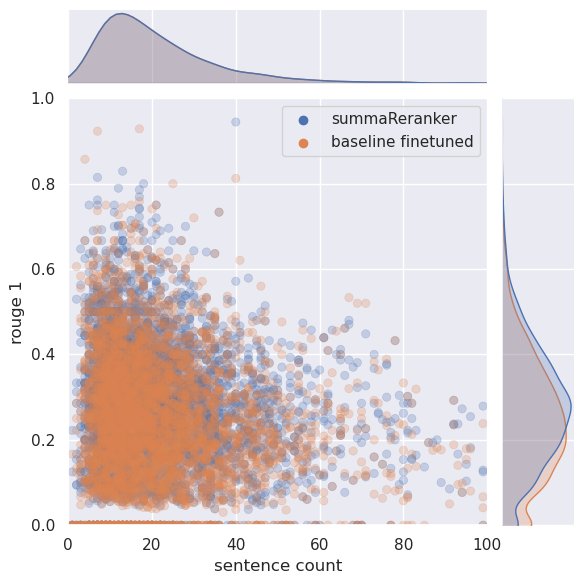

In [12]:
df_plot = get_df(length=sentcount_length, base=sentcount_base, ranker=sentcount_ranker)
jointplot(data=df_plot, xlabel="sentence count", ylabel="rouge 1", xlim=[0,100], ylim=[0, 1])

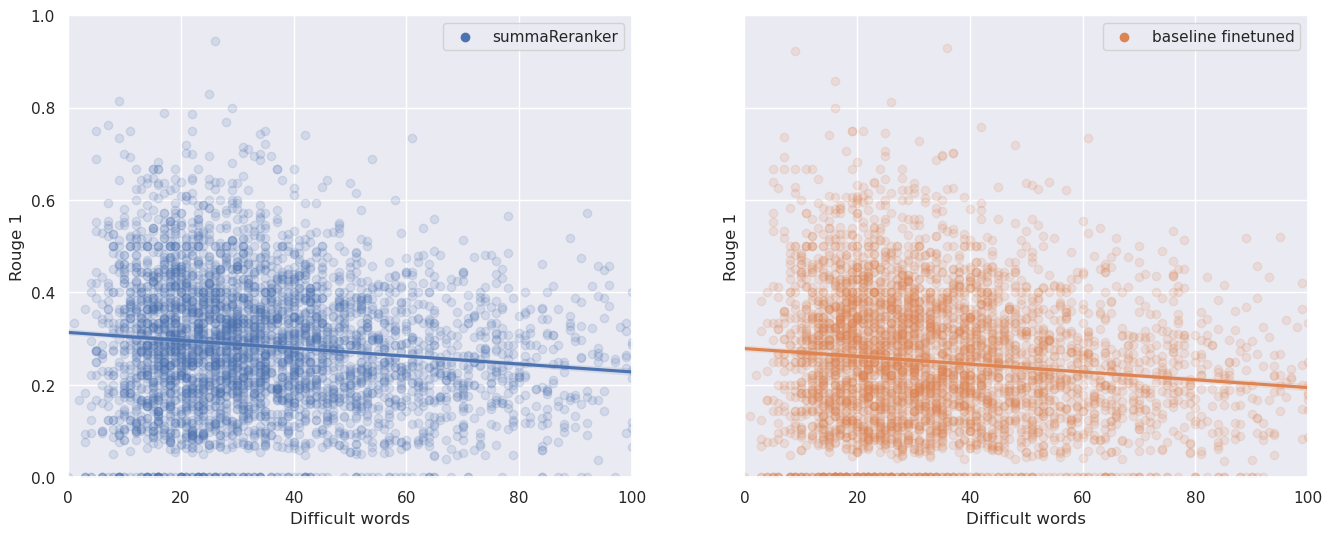

In [13]:
df_plot = get_df(length=difficult_words_length, base=difficult_words_base, ranker=difficult_words_ranker)
regplots(data=df_plot, xlabel="Difficult words", ylabel="Rouge 1", xlim=[0,100], ylim=[0, 1])

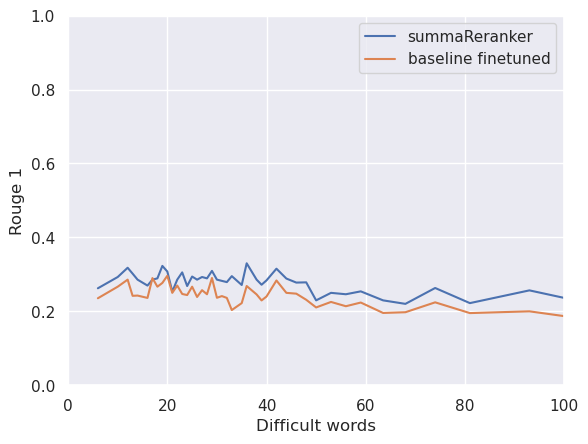

In [14]:
median_length = [np.median(b) for b in get_bins(difficult_words_length, 100)]
median_base = [np.median(b) for b in get_bins(difficult_words_base, 100)]
median_ranker = [np.median(b) for b in get_bins(difficult_words_ranker, 100)]

df_plot = get_df(length=median_length, base=median_base, ranker=median_ranker)
lineplot(data=df_plot, xlabel="Difficult words", ylabel="Rouge 1", xlim=[0,100], ylim=[0, 1])

In [15]:
median_length = [np.median(b) for b in get_bins(readability_length, 400)]
median_base = [np.median(b) for b in get_bins(readability_base, 400)]
median_ranker = [np.median(b) for b in get_bins(readability_ranker, 400)]

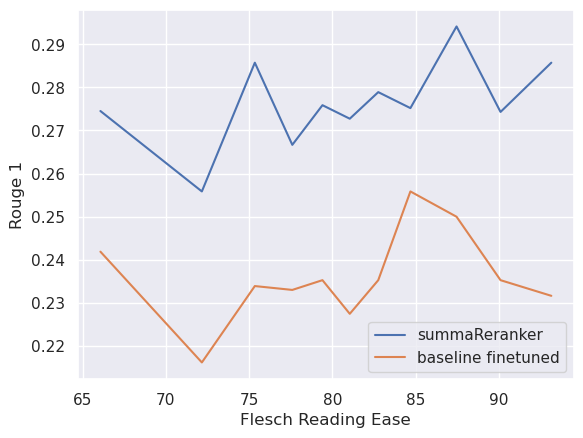

In [16]:
df_plot = get_df(length=median_length, base=median_base, ranker=median_ranker)
lineplot(data=df_plot, xlabel="Flesch Reading Ease", ylabel="Rouge 1")

## Evaluation Data Analysis - LMEMs

The question at hand is whether the SummaReranker actually improves the results of the base model?

At this point we want to create and fit two Linear Mixed Effects Models on our evaluation data. <br>
The two LMEMs are:
- **differentMeans model**: the formula for the initializing the lmem is "score ~ system + (1 | sentence_id)" and the model is fitted with these factors:<br> "system" : \["baseline_finetuned", "summaReranker"\]. This will specify the levels of our system
- **commonMeans model** : the formula will be: "score ~ (1 | sentence_id)". Here the levels of the system will be not specified. Because this model represents the assumption that the score are the same. 


In [17]:
def GLRT(mod1, mod2):
    chi_square = 2 * abs(mod1.logLike - mod2.logLike)
    delta_params = abs(len(mod1.coefs) - len(mod2.coefs)) 
    
    return {"chi_square" : chi_square, "df": delta_params, "p" : 1 - stats.chi2.cdf(chi_square, df=delta_params)}

In [18]:
result1, result2 = zip(*sorted(zip(ranker_total_scores, pegasus_reddit_scores), key=lambda x: x[0]))
result1 = result1[100:]
result2 = result2[100:]

In [19]:
median_base = [np.median(b) for b in get_bins(result1, 100)]
median_ranker = [np.median(b) for b in get_bins(result2, 100)]

### Experiments
The systems being tested: <br>
- fine-tuned PEGASUS Baseline <br>
- SummaReranker
    
Null hypothesis: the two systems are the same and there is no statistically significant difference between the expected scores    

In [20]:
data = []
for i in range(len(median_base)):
    data.append({"sentence_id": str(i), "system":"baseline_finetuned", "score": median_base[i]})
    data.append({"sentence_id": str(i), "system":"summaReranker","score": median_ranker[i]})

    
df = pd.DataFrame(data)
data = df.astype({"sentence_id" : 'category', "system" : 'category'})

differentMeans_model = Lmer(formula = "score ~ system + (1 | sentence_id)", data = data)
differentMeans_model.fit(factors = {"system" : ["baseline_finetuned", "summaReranker"]}, REML = False, summarize = False)

commonMean_model = Lmer(formula = "score ~ (1 | sentence_id)", data = data)
commonMean_model.fit(REML = False, summarize = False)

GLRT(differentMeans_model, commonMean_model)

{'chi_square': 25.367388428921885, 'df': 1, 'p': 4.738615906330068e-07}

Based on the results we can see that different Means model fits the data and based on the p-value we can reject the null hypothesis 

In [21]:
post_hoc_results = differentMeans_model.post_hoc(marginal_vars = ["system"])
post_hoc_results[0]

,system,Estimate,2.5_ci,97.5_ci,SE,DF
0,baseline_finetuned,0.295,0.252,0.338,0.021,42.953
1,summaReranker,0.269,0.226,0.311,0.021,42.953


In [22]:
post_hoc_results[1]

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
0,baseline_finetuned - summaReranker,0.026,0.017,0.036,0.004,42.0,5.902,0.0,***


The systems being tested: <br>
- fine-tuned PEGASUS Baseline <br>
- SummaReranker

In [23]:
result1, result2 = zip(*sorted(zip(ranker_total_scores, pegasus_unfinetuned_scores), key=lambda x: x[0]))
result1 = result1[100:]
result2 = result2[100:]

In [24]:
median_base = [np.median(b) for b in get_bins(result1, 100)]
median_ranker = [np.median(b) for b in get_bins(result2, 100)]

In [25]:
data = []
for i in range(len(median_base)):
    data.append({"sentence_id": str(i), "system":"baseline_notfinetuned", "score": median_base[i]})
    data.append({"sentence_id": str(i), "system":"summaReranker","score": median_ranker[i]})

    
df = pd.DataFrame(data)
data = df.astype({"sentence_id" : 'category', "system" : 'category'})

differentMeans_model = Lmer(formula = "score ~ system + (1 | sentence_id)", data = data)
differentMeans_model.fit(factors = {"system" : ["baseline_notfinetuned", "summaReranker"]}, REML = False, summarize = False)

commonMean_model = Lmer(formula = "score ~ (1 | sentence_id)", data = data)
commonMean_model.fit(REML = False, summarize = False)

GLRT(differentMeans_model, commonMean_model)

{'chi_square': 31.713674629121485, 'df': 1, 'p': 1.7865979584641423e-08}

In [26]:
post_hoc_results = differentMeans_model.post_hoc(marginal_vars = ["system"])
post_hoc_results[0]

,system,Estimate,2.5_ci,97.5_ci,SE,DF
0,baseline_notfinetuned,0.295,0.261,0.329,0.017,68.511
1,summaReranker,0.175,0.141,0.209,0.017,68.511


In [27]:
post_hoc_results[1]

,Contrast,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
0,baseline_notfinetuned - summaReranker,0.12,0.085,0.156,0.017,42.0,6.882,0.0,***


Also in this case, the null hypothesis can be rejected and we can see that there is a statistical difference between the two systems